In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

#### DEFINE VARIABLES

In [2]:
PATH = 'data/radar/'
DAY = sorted(os.listdir(PATH))[0]

#### READ FIRST FILES TO LOAD GLOBAL VARIABLES

In [3]:
first_file = PATH+str(DAY)+'/'+str(sorted(os.listdir(PATH+str(DAY)))[0])
try:
    xds = xr.open_dataset(first_file)   
except Exception as e:
    print('File not found')
    
RUNIT = xds.rain_rate.units
RKM = xds.rain_rate.height_km
LON = xds.lon0.data                 ### Coordinate Longitude Matrix
LAT = xds.lat0.data                 ### Corrdinate Latitude Matrix
X0 = xds.x0                         ### Matrix of points
Y0 = xds.y0
RADAR = (np.median(LON),np.median(LAT))

#### READ TIMES

In [4]:
def read_data(date):
    
    path = 'data/radar/'
    dataset = []
    interval = len(os.listdir(path+str(date)))    
    
    # Original grid dimensions
    nx = 241
    ny = 241

    # Define container
    frames = np.zeros( (interval, nx, ny ) )    
    
    for i in range(interval):
        d = str(path)+str(date)+'/'
        file = (sorted(os.listdir(path+str(date)))[i])
        xds = xr.open_dataset(d+file)
        rr = xds.rain_rate
        frames[i] =  rr
            
    return frames

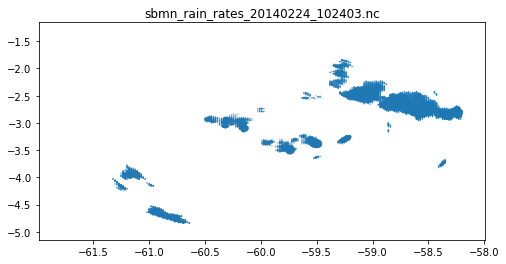

In [445]:
DAY = 20140224
figtime = 0
frames = read_data(DAY)

filename = sorted(os.listdir(PATH+str(DAY)))[figtime]
plt.figure(figsize=(8,4))
plt.title(filename)
plt.scatter(LON,LAT,frames[figtime])
plt.show();

In [6]:
def pre_processing(time):
    np.warnings.filterwarnings('ignore')
    
    ## thereshold value to track  2.85
    threshold = 21.8
    
    rs =  (np.where(time != np.nan) and np.where(time > threshold))
    rs = np.asanyarray(rs)
    pe = pd.DataFrame({'x1':rs[0],'y1':rs[1]})
        
    return pe

In [7]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

def dbscan(time):
    
    X = time

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # cluster the data into five clusters
    dbscan = DBSCAN(eps=0.1)
    clusters = dbscan.fit_predict(X_scaled)
    labels = dbscan.labels_
    
    time['cluster'] = labels
    time = time[(time['cluster'] >= 0)]
    
    return time

In [8]:
day = DAY
time = 15
frames = read_data(day)
clusters = dbscan(pre_processing(frames[time]))
clusters.head()

,x1,y1,cluster
0,105,163,0
1,105,164,0
2,106,163,0
3,106,164,0
4,106,165,0


In [694]:
def clusterization(time):
    te = time
    
    if len(te) < 2:
        return None
    
    bandwidth = estimate_bandwidth(te, quantile=0.1, n_samples=None, random_state=0, n_jobs=None)

    # first clusterization
    if bandwidth > 0:
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=None, cluster_all=True, min_bin_freq=1,
        n_jobs=None, seeds=None)

    ms.fit(te)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    te['cluster']=labels

    clust = pd.DataFrame()
    
    for i in range(n_clusters_):
        c2 = te.loc[te['cluster'] == i]
        c3 = ms2(c2[['x1','y1']])
        clust = clust.append(c3)
    
    clust['label1'] = te['cluster']
    clust = clust.reset_index(drop=True)
               
    return te

In [695]:
def ms2(time2):
    ms = MeanShift(bandwidth=3, bin_seeding=None, cluster_all=True, min_bin_freq=1,
    n_jobs=None, seeds=None)

    ms.fit(time2)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    time2['label2']=labels

    return time2

In [696]:
day = DAY
time = 15
frames = read_data(day)
clusters = clusterization(pre_processing(frames[time]))
clusters.head()

,x1,y1,cluster
0,105,163,2
1,105,164,2
2,106,163,2
3,106,164,2
4,106,165,2


In [697]:
# clusters.label1.iloc[0:3] = clusters.iloc[0:3].label1+1
# clusters.loc[clusters['label1'] == 1].sort_values('label2')

In [698]:
def create_data(day,time,frames,clusters):
    
    data = pd.DataFrame(columns=['DATETIME', 'N_CLUSTER','ID_CLUST','LON','LAT','R_FALL','DBZ'])

    # get values datetime
    dtime = xr.open_dataset(str(PATH)+str(day)+'/'+str(sorted(os.listdir(PATH+str(day)))[time])).start_time.values
    
    lat = (LAT[clusters['x1'],clusters['y1']])
    lon = (LON[clusters['x1'],clusters['y1']])
    
    # get values from RAIN_FALL
    rfall = (frames[clusters['x1'],clusters['y1']])
    
    data['LON'] = lon
    data['LAT'] = lat
    
    data['N_CLUSTER'] = len(clusters['cluster'].unique())
    data['ID_CLUST'] = clusters['cluster']
    data['X1'] = clusters['x1']
    data['Y1'] = clusters['y1']
    data['R_FALL'] = rfall
    data['DBZ'] = 10 * np.log10(200*data['R_FALL']**1.6)
    data['DATETIME'] = pd.to_datetime(dtime)
    
    data = data.set_index('DATETIME')
    
    # get 5 largest values from DBZ
    largest = 5
    cdata = pd.DataFrame()
    for i in range(data['N_CLUSTER'].max()):
        ct = data.loc[data['ID_CLUST'] == i]
        if ct.ID_CLUST.count() >= 3:
            cdata = cdata.append(ct)
            
    cdata['N_CLUSTER'] = len(cdata['ID_CLUST'].unique())
    cdata['ID_CLUST'] = cdata['ID_CLUST'].astype(int)
    
    del data,dtime,lat,lon,rfall,largest,ct
    
    return cdata

In [699]:
day = DAY
time = 11
frames = read_data(day)
clusters = clusterization(pre_processing(frames[time]))
# clusters = dbscan(pre_processing(frames[time]))

In [700]:
data = create_data(day,time,frames[time],clusters)
data.head()

,N_CLUSTER,ID_CLUST,LON,LAT,R_FALL,DBZ,X1,Y1
DATETIME,,,,,,,,
2014-02-24 12:36:06,9,0,-59.776115,-2.969615,22.796644,44.736235,130,132
2014-02-24 12:36:06,9,0,-59.794109,-2.951652,28.177818,46.208818,131,131
2014-02-24 12:36:06,9,0,-59.776119,-2.951649,132.966080,56.990154,131,132
2014-02-24 12:36:06,9,0,-59.758129,-2.951645,23.382477,44.912548,131,133
2014-02-24 12:36:06,9,0,-59.812103,-2.933689,39.176468,48.498704,132,130


In [728]:
data['geometry'] = list(zip(data.LON,data.LAT))
data.geometry = data.geometry.apply(Point)
gdata = gpd.GeoDataFrame(data,geometry='geometry')
gdata.crs = {'init' :'epsg:4326'}
gdata.to_file('shapefiles/points.shp')
gdata.head()

,N_CLUSTER,ID_CLUST,LON,LAT,R_FALL,DBZ,X1,Y1,geometry
DATETIME,,,,,,,,,
2014-02-24 12:36:06,9,0,-59.776115,-2.969615,22.796644,44.736235,130,132,POINT (-59.77611541748047 -2.96961522102356)
2014-02-24 12:36:06,9,0,-59.794109,-2.951652,28.177818,46.208818,131,131,POINT (-59.79410934448242 -2.95165228843689)
2014-02-24 12:36:06,9,0,-59.776119,-2.951649,132.966080,56.990154,131,132,POINT (-59.77611923217773 -2.951648950576782)
2014-02-24 12:36:06,9,0,-59.758129,-2.951645,23.382477,44.912548,131,133,POINT (-59.75812911987305 -2.951645135879517)
2014-02-24 12:36:06,9,0,-59.812103,-2.933689,39.176468,48.498704,132,130,POINT (-59.81210327148438 -2.93368935585022)


In [729]:
from shapely import wkt
def geo_data(cdata):
 
    cdata['geometry'] = list(zip(cdata.LON,cdata.LAT))
    cdata.geometry = cdata.geometry.apply(Point)
    cdata['geometry'] = cdata['geometry'].apply(lambda x: x.coords[0])
    cdata = cdata.groupby('ID_CLUST')['geometry'].apply(lambda x: Polygon(x.tolist()))
    cdata = gpd.GeoDataFrame(cdata, geometry = 'geometry')
    cdata.crs = {'init' :'epsg:4326'}
    return cdata

gdata = geo_data(data)
gdata['geometry'] = gdata.geometry.exterior

gdata.geometry.convex_hull.to_file('shapefiles/polygon.shp')
gdata.geometry.centroid.to_file('shapefiles/centroid.shp')

### CREATE TIFF FILE

In [737]:
#!/usr/bin/env python
from osgeo import gdal
from osgeo import osr
import numpy as np
import os, sys

#  Initialize the Image Size
image_size = (241,241)

lat = [-5.348556,-0.948556]
lon = [-62.192,-57.7919999]
            
# set geotransform
nx = image_size[0]
ny = image_size[1]
xmin, ymin, xmax, ymax = [min(lon), max(lat), max(lon), min(lat)]
# xmin, ymin, xmax, ymax = [min(lon), min(lat), max(lon), max(lat)]
xres = (xmax - xmin) / float(nx)
yres = (ymax - ymin) / float(ny)
geotransform = (xmin, xres, 0, ymax, 0, -yres)

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create('tiff/myGeoTIFF.tif', ny, nx, 1, gdal.GDT_Byte)

dst_ds.SetGeoTransform(geotransform)    # specify coords
srs = osr.SpatialReference()            # establish encoding
srs.ImportFromEPSG(4326)                # WGS84 lat/long
dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(frames[time])   # write a-band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### PLOT

In [765]:
import georaster
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors
import cartopy as cartopy
from matplotlib import cm, pyplot

In [705]:
fpath = r"tiff/myGeoTIFF.tif"
my_image = georaster.MultiBandRaster(fpath, load_data=False)

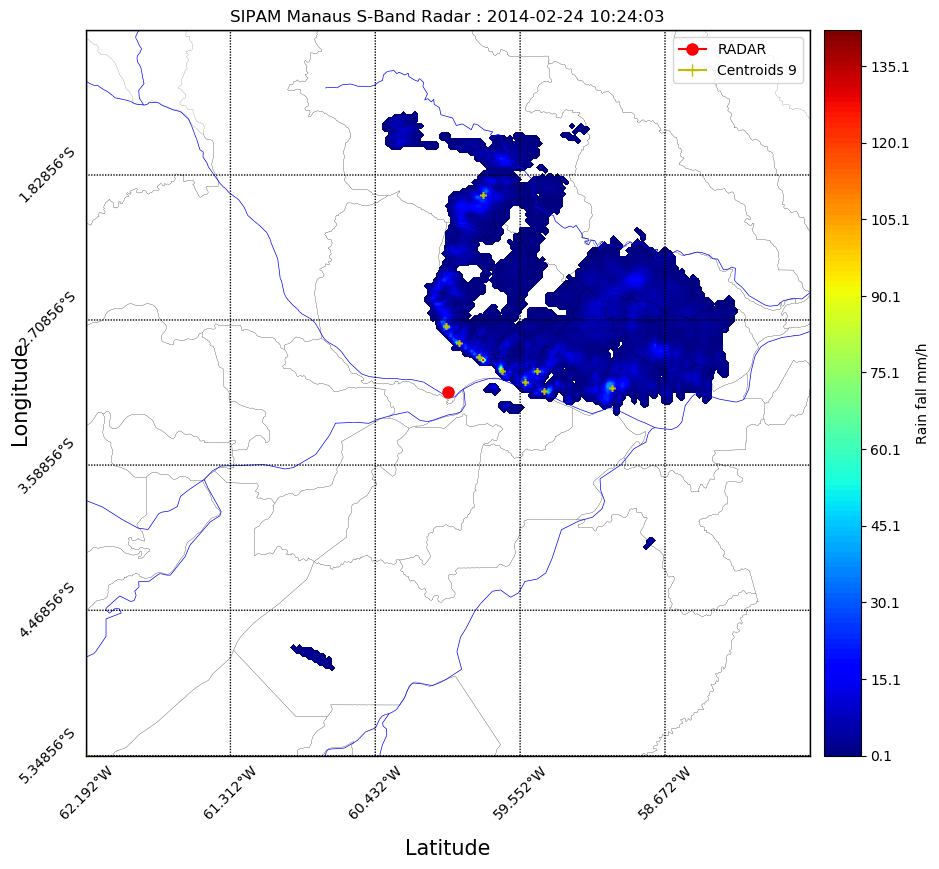

In [766]:
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
ax = axes

# grab limits of image's extent
minx, maxx, miny, maxy = my_image.extent

my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
zoom_scale = 2.2                       ## ZOOM SCALE

bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
             my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]

m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

cmap = mcolors.ListedColormap('viridis')


# # # # Add Grid Lines
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(10))
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(10))
m.drawmapboundary(fill_color='white')


# load the geotiff image, assign it a variable
image = georaster.SingleBandRaster( fpath, \
                        load_data=(minx, maxx, miny, maxy), \
                        latlon=True)

# read datetime from netCDF
date_time = xds.start_time.data
date_time = pd.to_datetime(date_time)

# # # # # Add Title
plt.title('SIPAM Manaus S-Band Radar : ' + str(date_time))
plt.ylabel('Longitude', labelpad=40, fontsize=15)
plt.xlabel('Latitude', labelpad=60, fontsize=15)


# plot the image on matplotlib active axes  xmin, xres, 0, ymax, 0, -yres  alpha=0.6
levels = np.arange(0.1,image.r.max()+10,1)

xm, ym = m(my_coords[1],my_coords[0])
radar = m.plot(xm,ym, marker='o',color='r', label='RADAR', markersize=8)

xi, yi = m(LON, LAT)
a = m.contourf(xi,yi,image.r,ax=ax,levels=levels, cmap = cm.jet)

b = m.readshapefile('./shapefiles/centroid', 'centroids')
c = m.readshapefile('./shapefiles/municipios/AM_Mun97_region', 'municipios', linewidth=0.1)
d = m.readshapefile('./shapefiles/hidro/lineaire_1km', 'hidrografia',color='b', linewidth=0.5)


for info, s in zip(m.centroids, m.centroids):
    m.plot(info[0],info[1],marker='+', color='y',markersize=2, markeredgewidth=5)
    
f = m.plot(0,0, marker='+',color='y', label='Centroids '+str(b[0]), markersize=8)

# d = plt.contourf(image.r, extent=(minx, maxx, maxy, miny), zorder=10, levels=levels, cmap='viridis')

# m.drawcoastlines(color="gray")
# m.fillcontinents(color='beige')

cbar = m.colorbar(a, size='5%',pad="2%")
cbar.set_label('Rain fall mm/h')
plt.legend()

plt.savefig('radar_image/'+ sorted(os.listdir(PATH+str(DAY)))[time]+'.png')
plt.show()